In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
file_path = "ibm.csv"
file_cleaned_path = "cleaned_ibm_data.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940   
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955   
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575   
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405   
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


#### Data Cleaning and Preprocessing

In [ ]:
data_filtered = data[["Date", "Open", "High", "Low", "Close", "Volume"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low     Close  Volume
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685


In [ ]:
data_cleaned.to_csv(file_cleaned_path, index=False)

In [ ]:
data = pd.read_csv(file_cleaned_path)
data.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,1.513320,407940
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,1.526548,305955
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,1.511336,274575
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,1.481573,384405
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,1.453794,572685


In [ ]:
#  Only 'Close' price is used for prediction
data_close= data["Close"].values.reshape(-1, 1)
data_close # N * 1 column vector

array([[  1.51332045],
       [  1.52654803],
       [  1.51133561],
       ...,
       [219.3500061 ],
       [219.72999573],
       [221.49000549]])

In [ ]:
# Data normalization using a MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)
data_scaled.shape

(15797, 1)

The output implies the presence of 15797 rows of data with one "closing price" feature

In [ ]:
features = ["Close"]

scaler = MinMaxScaler(feature_range=(0, 1))
data_transform = scaler.fit_transform(data[features])
data_transform_df = pd.DataFrame(columns=features, data=data_transform, index = data.index)

### Preparing data to feed into LSTM model

In [ ]:
def create_sequences(data, time_step):
    X = np.array([data[i : i + time_step, 0] for i in range(len(data) - time_step - 1)])
    y = np.array([data[i + time_step, 0] for i in range(len(data) - time_step - 1)])
    return X, y

In [ ]:
# Input reshaped to [samples, time steps, features]

time_step = 60
# X, y = create_sequences(data_scaled, time_step)
X, y = create_sequences(data_transform, time_step)
print(X.shape, y.shape)
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape, y.shape


(15736, 60) (15736,)


((15736, 60, 1), (15736,))

In [ ]:
# Data split into training and test sets (80:20 ratio)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_train.shape, X_test.shape

((12588, 60, 1), (3148, 60, 1))

In [ ]:
# Single Layer LSTM
def create_single_lstm_model(time_step, features=1, lr=0.001):
    model = Sequential()
    model.add(LSTM(units=50, activation="tanh", return_sequences=False, input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model
time_steps = 60
model_single_lstm = create_single_lstm_model(time_steps)

In [ ]:
# Train the model
history_single_lstm = model_single_lstm.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=25)

Epoch 1/25
355/355 [==============================] - 9s 22ms/step - loss: 2.8717e-04 - mean_absolute_error: 0.0082 - val_loss: 9.5965e-04 - val_mean_absolute_error: 0.0290
Epoch 2/25
355/355 [==============================] - 7s 21ms/step - loss: 7.4140e-05 - mean_absolute_error: 0.0049 - val_loss: 7.3897e-05 - val_mean_absolute_error: 0.0063
Epoch 3/25
355/355 [==============================] - 7s 19ms/step - loss: 5.6173e-05 - mean_absolute_error: 0.0043 - val_loss: 4.0487e-04 - val_mean_absolute_error: 0.0175
Epoch 4/25
355/355 [==============================] - 7s 19ms/step - loss: 5.4575e-05 - mean_absolute_error: 0.0044 - val_loss: 1.5874e-04 - val_mean_absolute_error: 0.0102
Epoch 5/25
355/355 [==============================] - 6s 18ms/step - loss: 5.0274e-05 - mean_absolute_error: 0.0045 - val_loss: 1.2365e-04 - val_mean_absolute_error: 0.0087
Epoch 6/25
355/355 [==============================] - 6s 17ms/step - loss: 4.6246e-05 - mean_absolute_error: 0.0043 - val_loss: 2.9053e

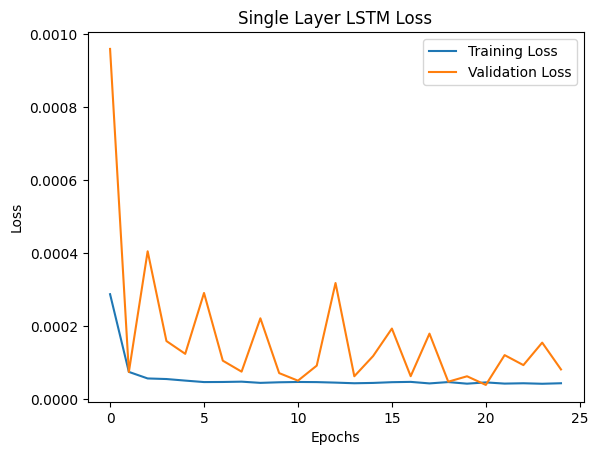

In [ ]:
plt.plot(history_single_lstm.history["loss"], label="Training Loss")
plt.plot(history_single_lstm.history["val_loss"], label="Validation Loss")
plt.title("Single Layer LSTM Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("LSTM_SINGLE_LOSS", bbox_inches="tight")

### Trying RNN and GRU models

In [ ]:
def create_rnn_model(time_step, features=1, lr=0.001):
    model = Sequential()
    model.add(
        SimpleRNN(units=50, return_sequences=True, activation="tanh", input_shape=(time_step, features))
    )
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=60))
    model.add(Dropout(0.2))
    model.add(Dense(units=30))
    model.add(Dense(units=15))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


time_steps = 60
model_rnn = create_rnn_model(time_steps)

In [ ]:

history_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=25)

Epoch 1/25
315/315 [==============================] - 10s 23ms/step - loss: 0.0025 - mean_absolute_error: 0.0226 - val_loss: 4.3859e-04 - val_mean_absolute_error: 0.0155
Epoch 2/25
315/315 [==============================] - 6s 20ms/step - loss: 2.0029e-04 - mean_absolute_error: 0.0076 - val_loss: 8.9755e-04 - val_mean_absolute_error: 0.0195
Epoch 3/25
315/315 [==============================] - 7s 22ms/step - loss: 1.2065e-04 - mean_absolute_error: 0.0059 - val_loss: 6.7905e-04 - val_mean_absolute_error: 0.0160
Epoch 4/25
315/315 [==============================] - 7s 22ms/step - loss: 9.7624e-05 - mean_absolute_error: 0.0052 - val_loss: 2.8784e-04 - val_mean_absolute_error: 0.0115
Epoch 5/25
315/315 [==============================] - 7s 23ms/step - loss: 7.6444e-05 - mean_absolute_error: 0.0048 - val_loss: 7.3293e-04 - val_mean_absolute_error: 0.0175
Epoch 6/25
315/315 [==============================] - 7s 23ms/step - loss: 7.7482e-05 - mean_absolute_error: 0.0047 - val_loss: 4.5859e-04

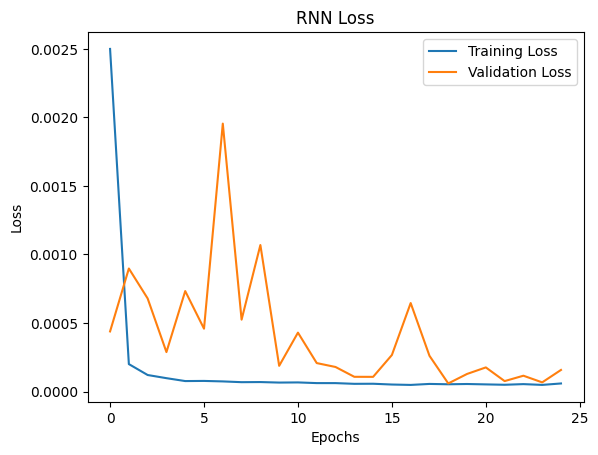

In [ ]:
plt.plot(history_rnn.history["loss"], label="Training Loss")
plt.plot(history_rnn.history["val_loss"], label="Validation Loss")
plt.title("RNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("RNN_LOSS.png", bbox_inches="tight")

## Intrepet the result


### Gated Recurrent Unit


In [ ]:
def create_gru_model(time_step, features=1, lr=0.001):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, activation="tanh", input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(GRU(units=60))
    model.add(Dropout(0.2))
    model.add(Dense(units=30))
    model.add(Dense(units=15))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model
time_steps = 60
model_gru = create_gru_model(time_steps)

In [ ]:
history_gru = model_gru.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=25)

Epoch 1/25
315/315 [==============================] - 19s 49ms/step - loss: 1.2735e-04 - mean_absolute_error: 0.0063 - val_loss: 4.7505e-05 - val_mean_absolute_error: 0.0052
Epoch 2/25
315/315 [==============================] - 14s 44ms/step - loss: 5.3623e-05 - mean_absolute_error: 0.0045 - val_loss: 8.5618e-05 - val_mean_absolute_error: 0.0074
Epoch 3/25
315/315 [==============================] - 14s 46ms/step - loss: 5.6145e-05 - mean_absolute_error: 0.0047 - val_loss: 1.1353e-04 - val_mean_absolute_error: 0.0092
Epoch 4/25
315/315 [==============================] - 13s 43ms/step - loss: 4.9923e-05 - mean_absolute_error: 0.0044 - val_loss: 3.3631e-05 - val_mean_absolute_error: 0.0042
Epoch 5/25
315/315 [==============================] - 14s 45ms/step - loss: 5.7469e-05 - mean_absolute_error: 0.0048 - val_loss: 7.6984e-05 - val_mean_absolute_error: 0.0070
Epoch 6/25
315/315 [==============================] - 14s 43ms/step - loss: 5.7724e-05 - mean_absolute_error: 0.0046 - val_loss: 6

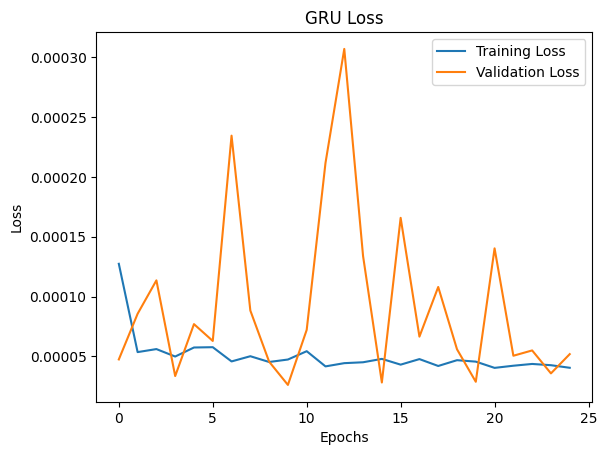

In [ ]:
plt.plot(history_gru.history["loss"], label="Training Loss")
plt.plot(history_gru.history["val_loss"], label="Validation Loss")
plt.title("GRU Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("GRU_LOSS.png", bbox_inches="tight")

### Use Multi_Layer LSTM model

In [ ]:
# Multi layer LSTM model definition
def create_multi__lstm_model(time_step, features=1, lr=0.001):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, activation="tanh", input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

time_steps = 60
model_multi_lstm = create_multi__lstm_model(time_steps)

In [ ]:
history_multi_lstm = model_multi_lstm.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=25)

Epoch 1/25
315/315 [==============================] - 19s 51ms/step - loss: 2.1779e-04 - mean_absolute_error: 0.0072 - val_loss: 2.8776e-04 - val_mean_absolute_error: 0.0132
Epoch 2/25
315/315 [==============================] - 14s 46ms/step - loss: 8.2472e-05 - mean_absolute_error: 0.0049 - val_loss: 8.8992e-05 - val_mean_absolute_error: 0.0066
Epoch 3/25
315/315 [==============================] - 15s 47ms/step - loss: 7.1459e-05 - mean_absolute_error: 0.0045 - val_loss: 2.1000e-04 - val_mean_absolute_error: 0.0106
Epoch 4/25
315/315 [==============================] - 15s 47ms/step - loss: 7.7738e-05 - mean_absolute_error: 0.0050 - val_loss: 3.3293e-04 - val_mean_absolute_error: 0.0139
Epoch 5/25
315/315 [==============================] - 14s 46ms/step - loss: 7.0342e-05 - mean_absolute_error: 0.0049 - val_loss: 8.1363e-05 - val_mean_absolute_error: 0.0062
Epoch 6/25
315/315 [==============================] - 14s 45ms/step - loss: 7.0755e-05 - mean_absolute_error: 0.0048 - val_loss: 8

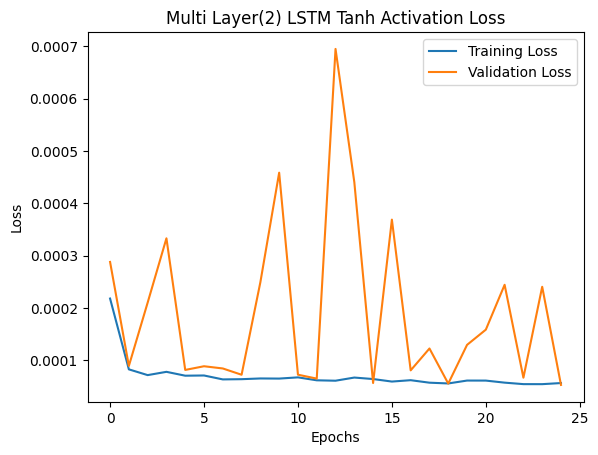

In [ ]:
plt.plot(history_multi_lstm.history["loss"], label="Training Loss")
plt.plot(history_multi_lstm.history["val_loss"], label="Validation Loss")
plt.title("Multi Layer(2) LSTM Tanh Activation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("LSTM_MULTI_LOSS.png", bbox_inches="tight")

## Testing the model on RNN

In [ ]:
# Predict stock prices on the test set
predicted_stock_price = model_rnn.predict(X_test)

99/99 [==============================] - 1s 6ms/step


In [ ]:
# We get the actual stock price by inverse transforming the actual predicted stock price

predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#### Calculating Error Metrices (MSE, RMSE and MAE)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_rnn)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_rnn)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 94.33888352993779
Root Mean Squared Error (RMSE): 9.712820575401246
Mean Absolute Error (MAE): 8.213101586968351


## Testing the model on GRU

In [ ]:
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price_gru = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_gru)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_gru)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 [==============================] - 1s 11ms/step
Mean Squared Error (MSE): 7.542088524285248
Root Mean Squared Error (RMSE): 2.7462863150598933
Mean Absolute Error (MAE): 2.1324410032589824


### Testing the model on Single_Layer_LSTM


In [ ]:
predicted_stock_price = model_single_lstm.predict(X_test)
predicted_stock_price_lstm_single = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_single)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_single)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 [==============================] - 1s 7ms/step
Mean Squared Error (MSE): 15.021875200032824
Root Mean Squared Error (RMSE): 3.8758063935177183
Mean Absolute Error (MAE): 3.297128039969574


### Testing the model on Multi_Layer_LSTM

In [ ]:
predicted_stock_price = model_multi_lstm.predict(X_test)
predicted_stock_price_lstm_multi = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_multi)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_multi)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 [==============================] - 2s 14ms/step
Mean Squared Error (MSE): 29.250427128983116
Root Mean Squared Error (RMSE): 5.4083664011402846
Mean Absolute Error (MAE): 4.020925407942853


### We target to imrpove the LSTM model at predictionso
### We will try hyperparamters tuning
### Based on the professor's recommendation, we'll try to use tanh and observe any peformance changes/imrpovement

In [ ]:
def create_multi_lstm_tanh_model(time_step, features=1, lr=0.001):
    model = Sequential()
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(time_step, features),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=60,
            return_sequences=True,
            activation="tanh",
        )
    )
    model.add(Dropout(0.3))
    model.add(LSTM(
        units = 80,
        activation = 'tanh',
        )
    )
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation="linear"))
    # The inear activation at the output layer allows unrestricted output
    # model.add(Dense(units=1, activation='tanh'))  # if output values are expected within [-1, 1]
    # Since a stock prediction is a regression problem, a RMSE loss should be apt for this case
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


time_steps = 60
model_multi_lstm_tanh = create_multi_lstm_tanh_model(time_steps)

Validation while training might hinder the learning, so we try without validation

In [ ]:
history_multi_lstm_model_tanh = model_multi_lstm_tanh.fit(
    X_train, y_train, batch_size=32, epochs=25
)

Epoch 1/25
394/394 [==============================] - 26s 65ms/step - loss: 2.4143e-04 - mean_absolute_error: 0.0099
Epoch 2/25
394/394 [==============================] - 26s 65ms/step - loss: 1.9620e-04 - mean_absolute_error: 0.0092
Epoch 3/25
394/394 [==============================] - 26s 65ms/step - loss: 2.0546e-04 - mean_absolute_error: 0.0095
Epoch 4/25
394/394 [==============================] - 27s 68ms/step - loss: 1.8401e-04 - mean_absolute_error: 0.0091
Epoch 5/25
394/394 [==============================] - 27s 69ms/step - loss: 1.7864e-04 - mean_absolute_error: 0.0090
Epoch 6/25
394/394 [==============================] - 27s 67ms/step - loss: 1.8414e-04 - mean_absolute_error: 0.0091
Epoch 7/25
394/394 [==============================] - 25s 63ms/step - loss: 1.8708e-04 - mean_absolute_error: 0.0091
Epoch 8/25
394/394 [==============================] - 24s 60ms/step - loss: 1.7532e-04 - mean_absolute_error: 0.0088
Epoch 9/25
394/394 [==============================] - 23s 59ms/s

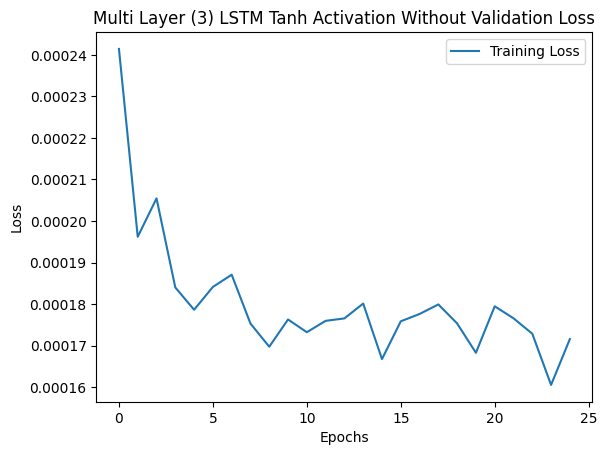

In [ ]:
plt.plot(history_multi_lstm_model_tanh.history["loss"], label="Training Loss")
# plt.plot(history_multi_lstm_model_tanh.history["val_loss"], label="Validation Loss")
plt.title("Multi Layer (3) LSTM Tanh Activation Without Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("MULTI_LSTM_TANH.png", bbox_inches="tight")

### Training with a validation loss

In [ ]:
history_multi_lstm_model_tanh_with_validation = model_multi_lstm_tanh.fit(
    X_train, y_train, validation_split=0.2, batch_size=32, epochs=25
)

Epoch 1/25
315/315 [==============================] - 27s 79ms/step - loss: 2.3602e-04 - mean_absolute_error: 0.0081 - val_loss: 7.0382e-04 - val_mean_absolute_error: 0.0220
Epoch 2/25
315/315 [==============================] - 22s 68ms/step - loss: 1.2817e-04 - mean_absolute_error: 0.0064 - val_loss: 0.0024 - val_mean_absolute_error: 0.0432
Epoch 3/25
315/315 [==============================] - 23s 74ms/step - loss: 1.2675e-04 - mean_absolute_error: 0.0064 - val_loss: 1.5831e-04 - val_mean_absolute_error: 0.0095
Epoch 4/25
315/315 [==============================] - 24s 75ms/step - loss: 9.9690e-05 - mean_absolute_error: 0.0056 - val_loss: 8.5410e-04 - val_mean_absolute_error: 0.0245
Epoch 5/25
315/315 [==============================] - 23s 74ms/step - loss: 1.0145e-04 - mean_absolute_error: 0.0058 - val_loss: 1.3147e-04 - val_mean_absolute_error: 0.0088
Epoch 6/25
315/315 [==============================] - 22s 69ms/step - loss: 9.5717e-05 - mean_absolute_error: 0.0057 - val_loss: 3.501

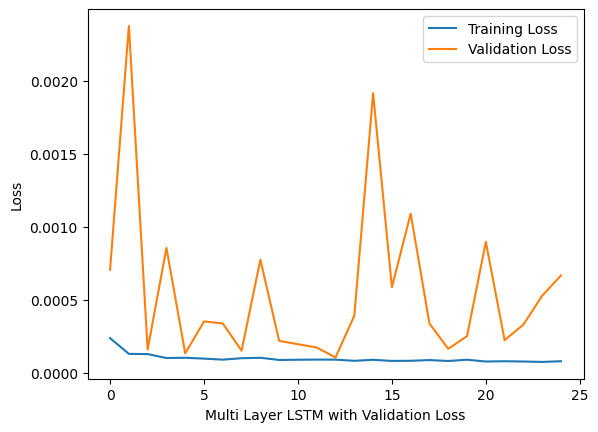

In [ ]:
plt.plot(
    history_multi_lstm_model_tanh_with_validation.history["loss"], label="Training Loss"
)
plt.plot(
    history_multi_lstm_model_tanh_with_validation.history["val_loss"],
    label="Validation Loss",
)
plt.xlabel("Multi Layer LSTM with Validation Loss")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("MULTI_LSTM_TANH_VALIDATION.png", bbox_inches="tight")

### Testing the model on Multi_Layer_LSTM_Tanh

In [ ]:
predicted_stock_price = model_multi_lstm_tanh.predict(X_test)
predicted_stock_price_lstm_multi_tanh = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_multi_tanh)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_multi_tanh)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 [==============================] - 2s 24ms/step
Mean Squared Error (MSE): 171.79584232469514
Root Mean Squared Error (RMSE): 13.107091299166843
Mean Absolute Error (MAE): 6.610749757274739


In [ ]:
dates = data["Date"].values
dates

array(['1962-01-02 00:00:00-05:00', '1962-01-03 00:00:00-05:00',
       '1962-01-04 00:00:00-05:00', ..., '2024-10-01 00:00:00-04:00',
       '2024-10-02 00:00:00-04:00', '2024-10-03 00:00:00-04:00'],
      dtype=object)

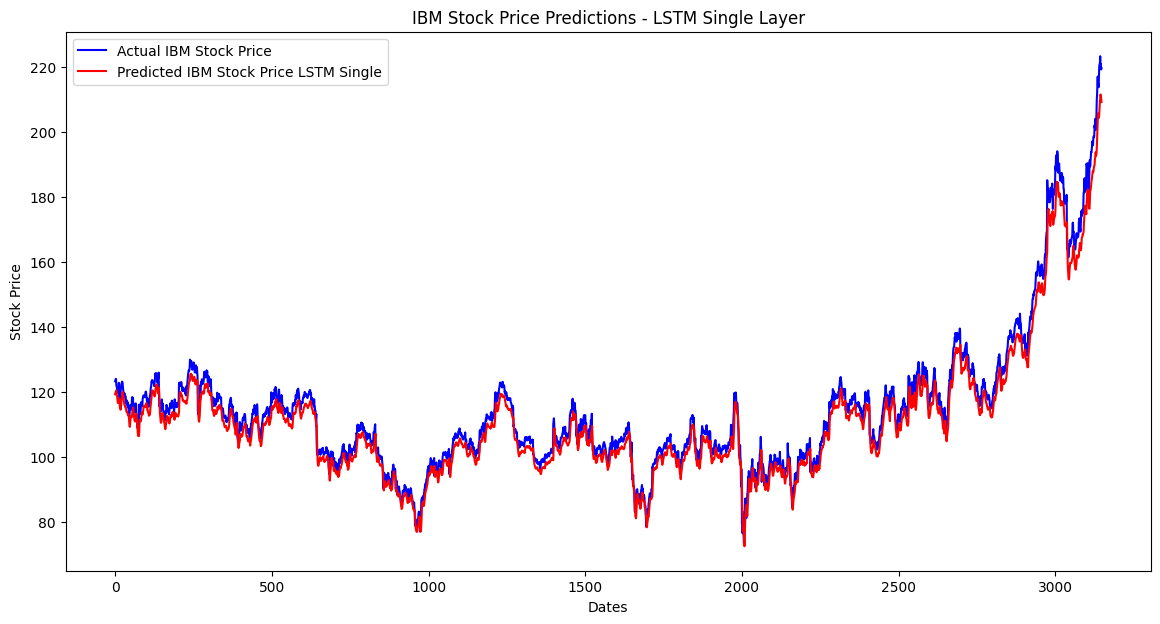

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_single, color="red", label="Predicted IBM Stock Price LSTM Single")
plt.title("IBM Stock Price Predictions - LSTM Single Layer")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

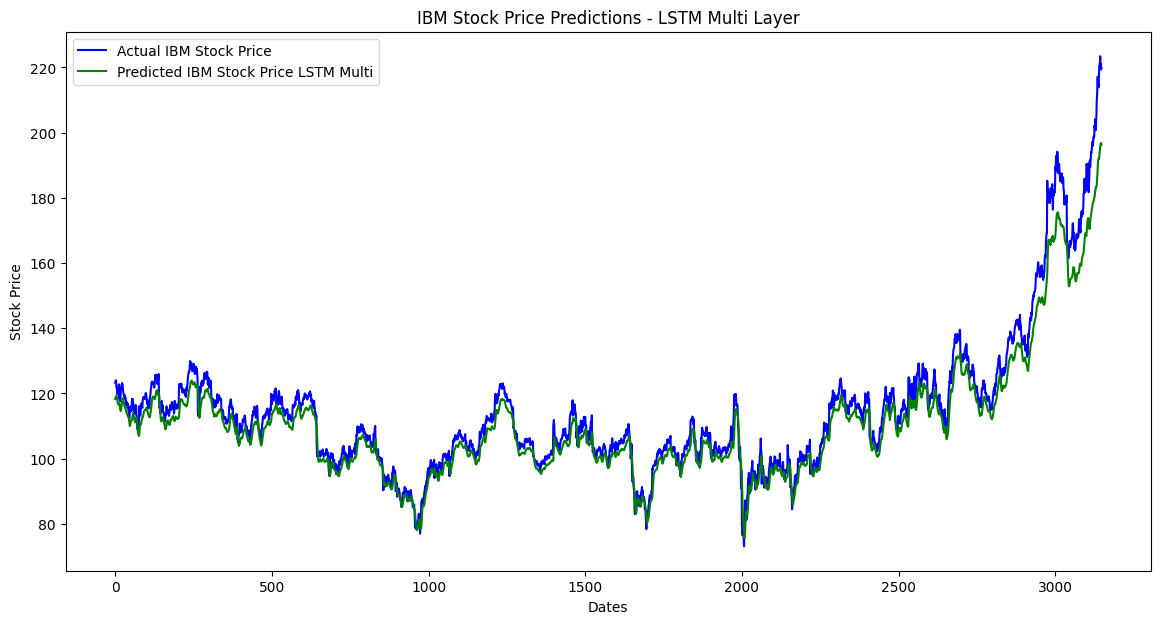

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_multi, color="green", label="Predicted IBM Stock Price LSTM Multi")
plt.title("IBM Stock Price Predictions - LSTM Multi Layer")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

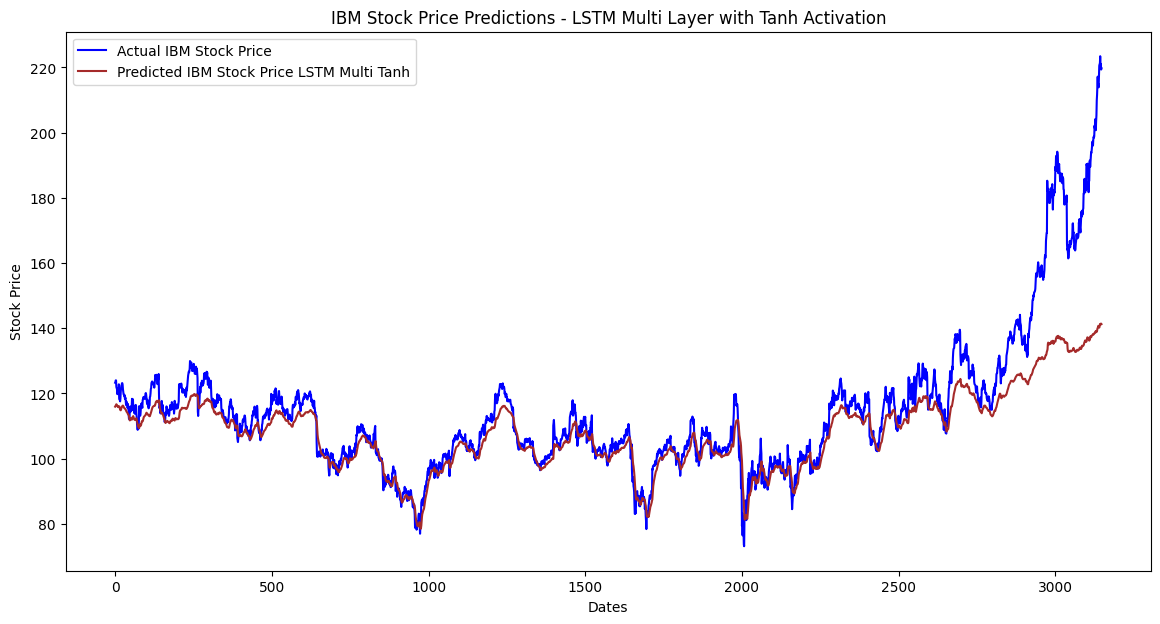

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_multi_tanh, color="brown", label="Predicted IBM Stock Price LSTM Multi Tanh")
plt.title("IBM Stock Price Predictions - LSTM Multi Layer with Tanh Activation")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

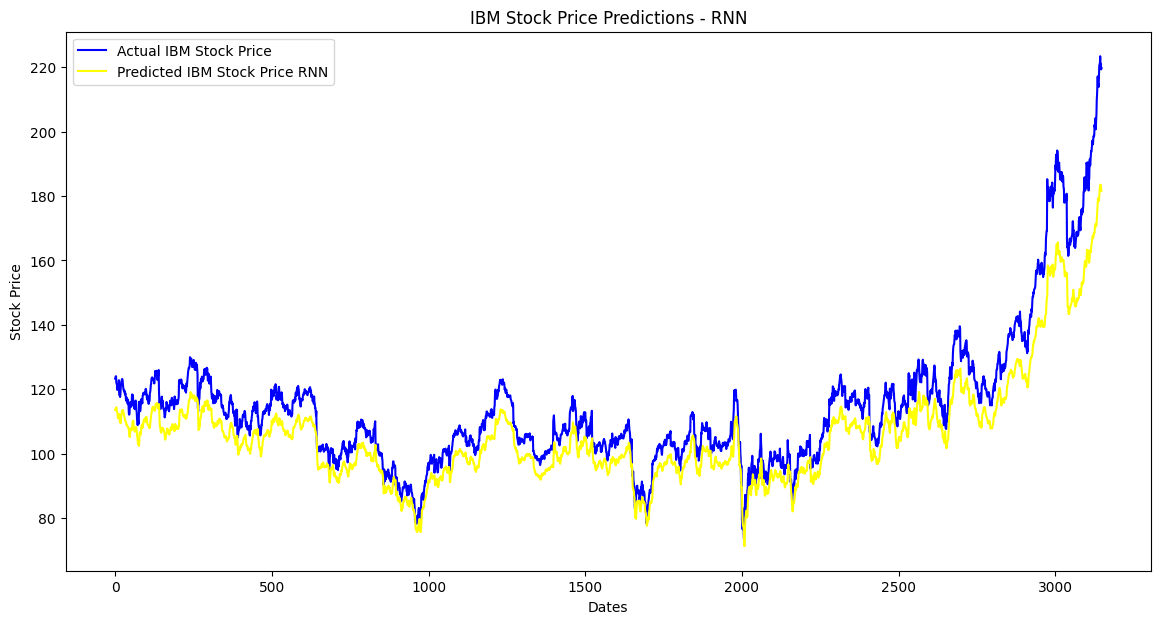

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_rnn, color="yellow", label="Predicted IBM Stock Price RNN")
plt.title("IBM Stock Price Predictions - RNN")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

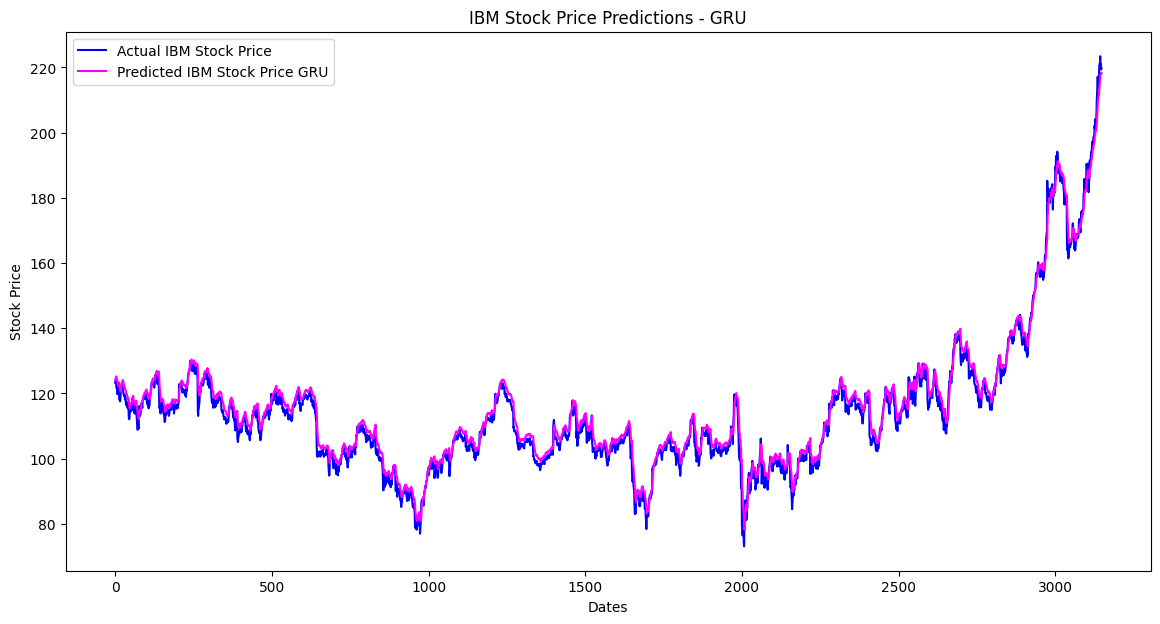

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_gru, color="magenta", label="Predicted IBM Stock Price GRU")
plt.title("IBM Stock Price Predictions - GRU")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

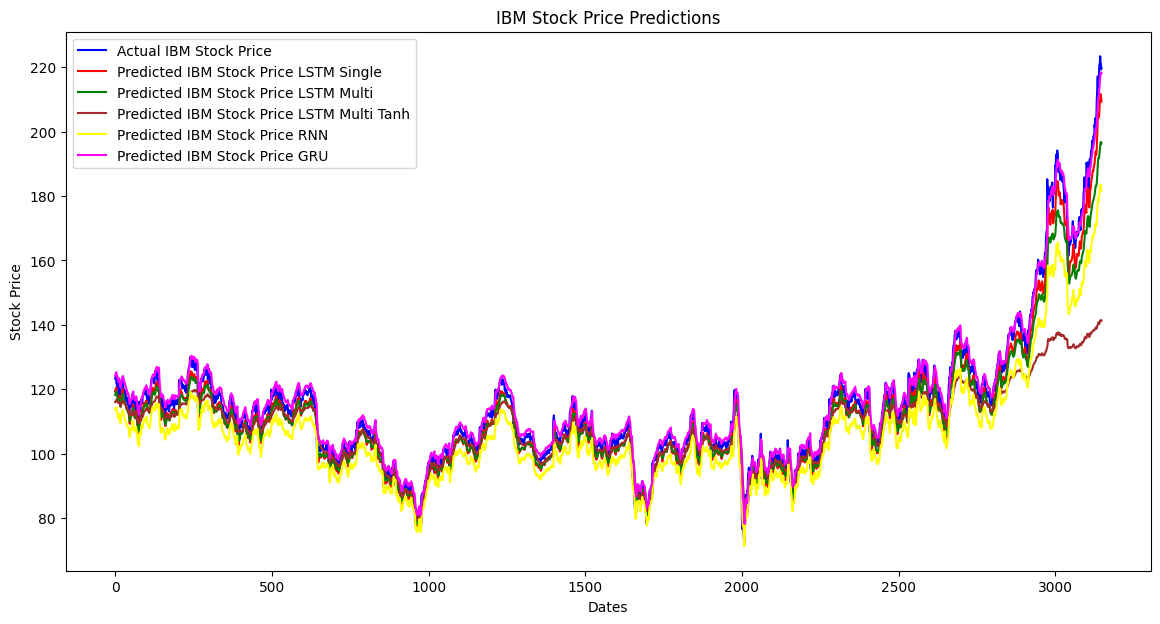

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_single, color="red", label="Predicted IBM Stock Price LSTM Single")
plt.plot(predicted_stock_price_lstm_multi, color="green", label="Predicted IBM Stock Price LSTM Multi")
plt.plot(predicted_stock_price_lstm_multi_tanh, color="brown", label="Predicted IBM Stock Price LSTM Multi Tanh")
plt.plot(predicted_stock_price_rnn, color="yellow", label="Predicted IBM Stock Price RNN")
plt.plot(predicted_stock_price_gru, color="magenta", label="Predicted IBM Stock Price GRU")
plt.title("IBM Stock Price Predictions")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()